In [1]:
import networkx as nx
import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from simulate import ODE_simulate, GILL_simulate
from plot_module import plot_ODE, plot_gillespie, plot_network
from sim_param_from_network import names_from_network, gillespie_param_from_network, dataframes_from_network, ODE_from_network
from network_generate import network_gen_chain

import libgillespie

In [2]:
MAX_T = 10000
TIME_POINTS = np.linspace(0, MAX_T, 101)

## Define network topology and numeric parameters

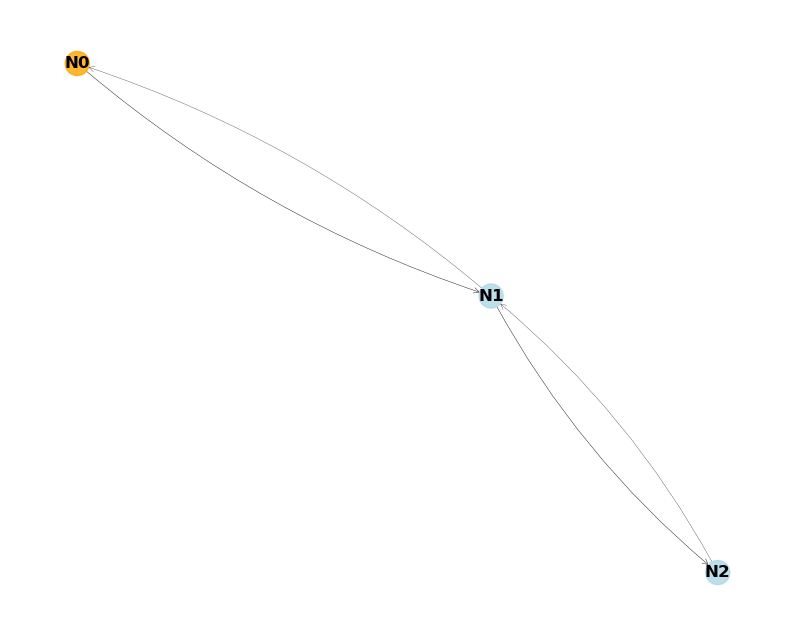

In [3]:
C_B = 0.1
MU_AXON = 0.07
NSS = 100
DELTA = 0.5
MU = 0.03
GAMMA_ANT = 0.3
GAMMA_RET = 0.2

bio_param = {'soma_cb':C_B, 'soma_br':MU_AXON, 'soma_nss':NSS, 'delta':DELTA, 'turnover':MU, 'gamma_ant':GAMMA_ANT, 'gamma_ret':GAMMA_RET}
G, VARS, COMP, START_STATE = network_gen_chain(3, [90, 20], bio_param, )
plot_network(G)

## Get ODE representation of network, and run simulation

In [4]:
ODE_model = ODE_from_network(G)

>> Code for ODE model:

global ODE_model
def ODE_model(t, z):
	# variables (node name + wt/mt)
	N0_wt, N0_mt, N1_wt, N1_mt, N2_wt, N2_mt = z
	return [
		# ΔN0_wt/Δt
		(N0_wt*((0.07 + 0.1*(100-N0_wt-(0.5*N0_mt)))-(0.03)-(0.3)))+(N1_wt*0.2),
		# ΔN0_mt/Δt
		(N0_mt*((0.07 + 0.1*(100-N0_wt-(0.5*N0_mt)))-(0.03)-(0.3)))+(N1_mt*0.2),
		# ΔN1_wt/Δt
		(N1_wt*(0-(0.03)-(0.5)))+(N0_wt*0.3)+(N2_wt*0.2),
		# ΔN1_mt/Δt
		(N1_mt*(0-(0.03)-(0.5)))+(N0_mt*0.3)+(N2_mt*0.2),
		# ΔN2_wt/Δt
		(N2_wt*(0-(0.03)-(0.2)))+(N1_wt*0.3),
		# ΔN2_mt/Δt
		(N2_mt*(0-(0.03)-(0.2)))+(N1_mt*0.3),
		]


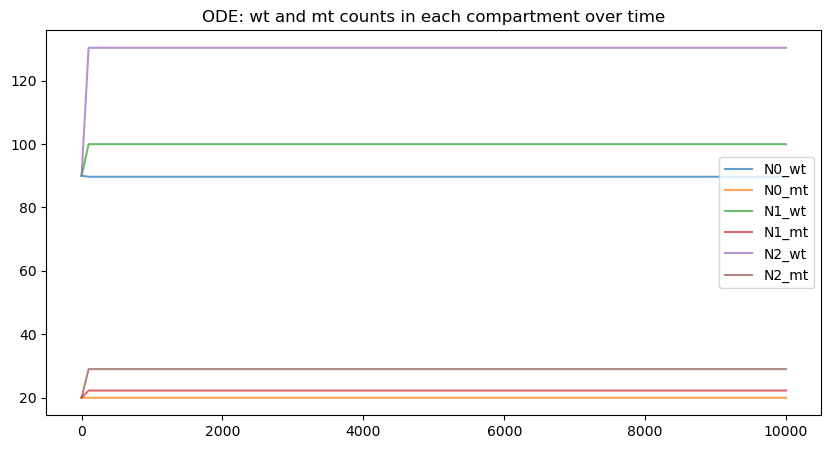

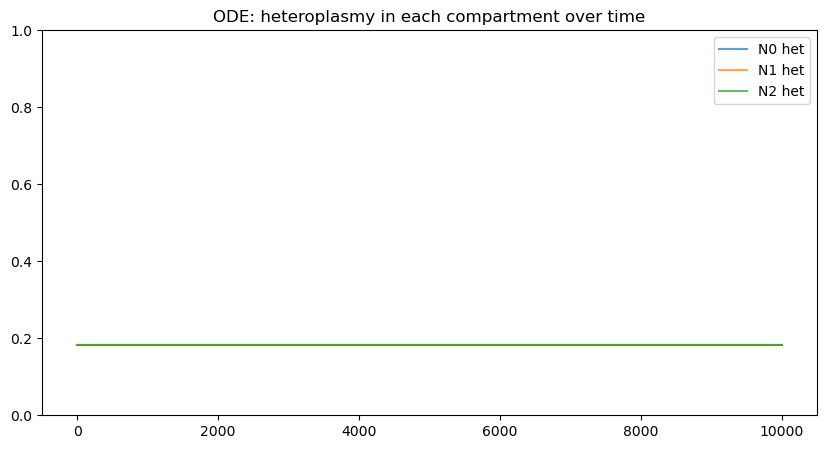

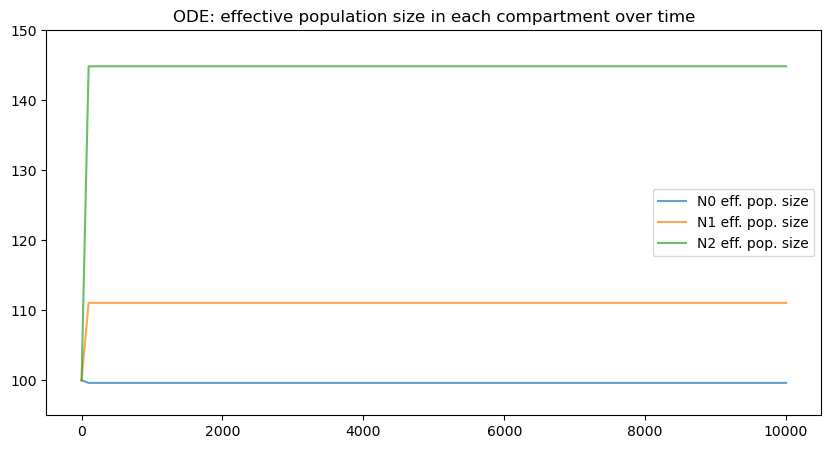

> Final counts of mt and wt in each compartment:
N0_wt	89.6665	
N0_mt	19.9259	
N1_wt	99.9513	
N1_mt	22.2114	
N2_wt	130.3713	
N2_mt	28.9714	

> Final effective population sizes in each compartment:
N0	99.6294	
N1	111.057	
N2	144.857	


In [5]:
ode_results = ODE_simulate(ODE_model, TIME_POINTS, START_STATE)
plot_ODE(ode_results, TIME_POINTS, DELTA, VARS, COMP)

## Get gillespie simulation for network

In [6]:
GILL_PARAM = gillespie_param_from_network(G)


>> Gillespie simulation parameters:

> Reactions:
react.#	state i	type	rate	update to system
0	0	birth	-1	[1, 0, 0, 0, 0, 0]
1	1	birth	-1	[0, 1, 0, 0, 0, 0]
2	0	death	0.03	[-1, 0, 0, 0, 0, 0]
3	1	death	0.03	[0, -1, 0, 0, 0, 0]
4	2	death	0.03	[0, 0, -1, 0, 0, 0]
5	3	death	0.03	[0, 0, 0, -1, 0, 0]
6	4	death	0.03	[0, 0, 0, 0, -1, 0]
7	5	death	0.03	[0, 0, 0, 0, 0, -1]
8	0	trnspt	0.3	[-1, 0, 1, 0, 0, 0]
9	1	trnspt	0.3	[0, -1, 0, 1, 0, 0]
10	2	trnspt	0.2	[1, 0, -1, 0, 0, 0]
11	3	trnspt	0.2	[0, 1, 0, -1, 0, 0]
12	2	trnspt	0.3	[0, 0, -1, 0, 1, 0]
13	3	trnspt	0.3	[0, 0, 0, -1, 0, 1]
14	4	trnspt	0.2	[0, 0, 1, 0, -1, 0]
15	5	trnspt	0.2	[0, 0, 0, 1, 0, -1]

> Dynamic birth rates:
react.#	state i	[c_b, mu, nss, delta]
0, 1	0	[0.1, 0.07, 100.0, 0.5]


In [7]:
%%time
gill_results = GILL_simulate(GILL_PARAM, TIME_POINTS, START_STATE, replicates = 5000)

simulating...
CPU times: user 26min 37s, sys: 937 ms, total: 26min 38s
Wall time: 26min 36s


In [8]:
def get_result_statistics(
        replicate_results,  # variable values over time (number of wildtype and mutant in each compartment)
        time_points,        # time points where system is sampled
        delta,              # mutant deficiency, used in calculating effective population sizes
        vari,               # name of the variables being tracked (compartment name + wt/mt)
        comp                # name of the compartments (e.g. soma, axon, etc.)
        ):
    
    n_vars = len(vari)
    n_comp = len(comp)
    
    # separate out wt and mt counts per compartment
    wt_counts = replicate_results[:,np.arange(0, n_vars, 2),:]
    mt_counts = replicate_results[:,np.arange(1, n_vars, 2),:]
    
    # get the number of wt and mt in the full system (summed over compartments)
    wt_totals = np.sum(wt_counts, axis = 1)
    mt_totals = np.sum(mt_counts, axis = 1)    

    # get mean counts of each variable over time
    mean_var_value = np.mean(replicate_results, axis=0)

    # get the mean heteroplasmy of each compartment
    mean_per_comp_het= np.mean(mt_counts/(wt_counts+mt_counts), axis = 0)
    
    # get the mean effective population size of each compartment
    mean_per_comp_het= np.mean(mt_counts*delta + wt_counts, axis = 0)
    
    # get the total heteroplasmies of all the replicatse
    total_het = mt_totals/(wt_totals+mt_totals)
    
    # get the total heteroplasmies in the last time point
    final_total_het = total_het[:,-1]
    
    return final_total_het
    
final_het_sampe = get_result_statistics(gill_results, TIME_POINTS, DELTA, VARS, COMP)

(array([ 4.,  6., 11., 13., 18., 21., 18.,  5.,  2.,  2.]),
 array([0.49485997, 0.52722718, 0.5595944 , 0.59196161, 0.62432882,
        0.65669604, 0.68906325, 0.72143047, 0.75379768, 0.7861649 ,
        0.81853211]),
 <BarContainer object of 10 artists>)

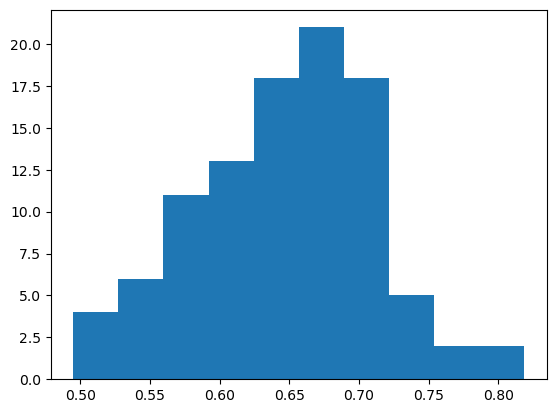

In [13]:
def sample_means(sample, batchsize = 50):
    assert sample.size % batchsize == 0, 'number of samples must be divisible by the batch size'
    sample = np.reshape(sample, (int(sample.size/batchsize), batchsize))
    return np.mean(sample, axis = 1)
    
means = sample_means(final_het_sampe)
plt.hist(means)

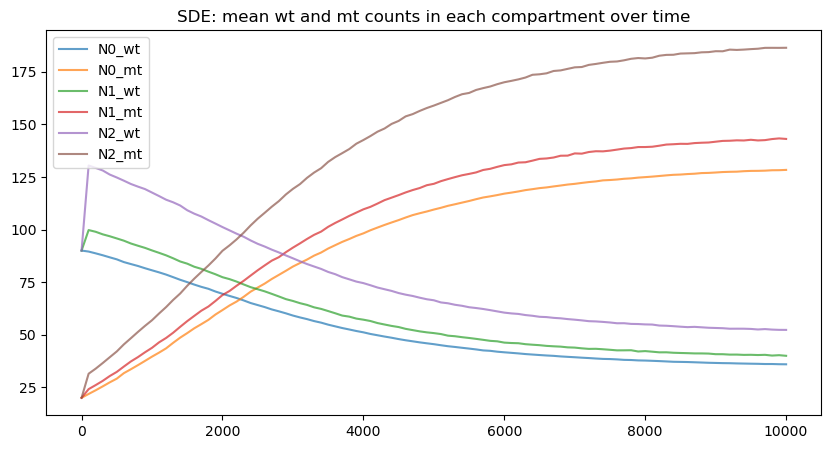

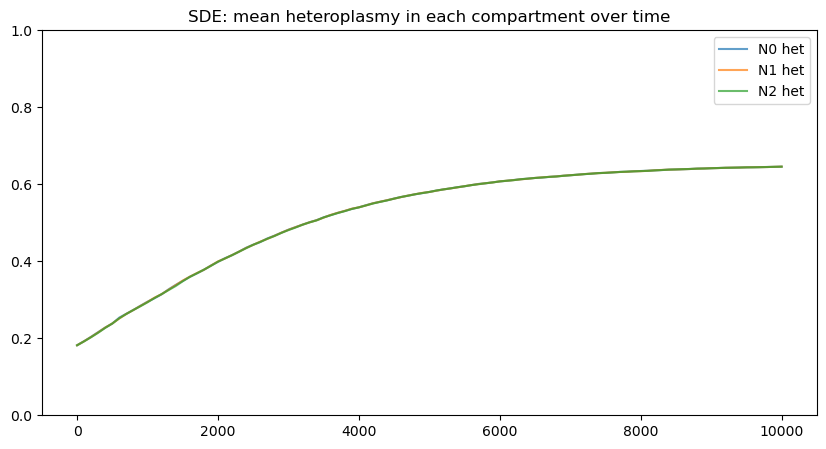

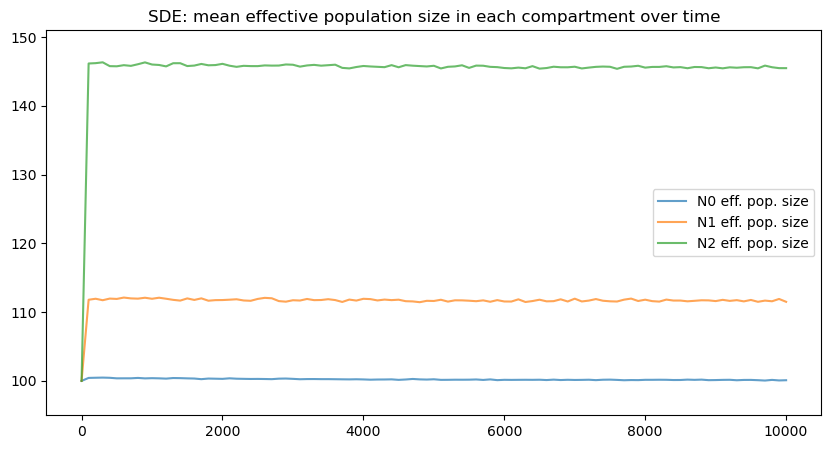

> Final mean counts of mt and wt in each compartment:
N0_wt	35.9188	
N0_mt	128.358	
N1_wt	39.9616	
N1_mt	143.083	
N2_wt	52.2774	
N2_mt	186.4284	

> Final mean heteroplasmy in each compartment:
N0	0.6458	
N1	0.6458	
N2	0.6457	

> Final mean effective population sizes in each compartment:
N0	100.0978	
N1	111.5031	
N2	145.4916	

> Change in mean heteroplasmy: 
start: 0.1818
final: 0.6445
delta: 0.4627


In [10]:
plot_gillespie(gill_results, TIME_POINTS, DELTA, VARS, COMP)